<a href="https://colab.research.google.com/github/ValentinRicher/understanding-decision-trees/blob/master/understanding_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding decision trees (once and for all !)


In this notebook we will describe how a decision tree is built and how it takes its decision for new data points once built.

## 1- Importing libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
import graphviz
from IPython.display import Image, display
import pydotplus

## 2- Loading the data

In [2]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
5,5.4,3.9,1.7,0.4,0.0
6,4.6,3.4,1.4,0.3,0.0
7,5.0,3.4,1.5,0.2,0.0
8,4.4,2.9,1.4,0.2,0.0
9,4.9,3.1,1.5,0.1,0.0


## 2- Data exploration

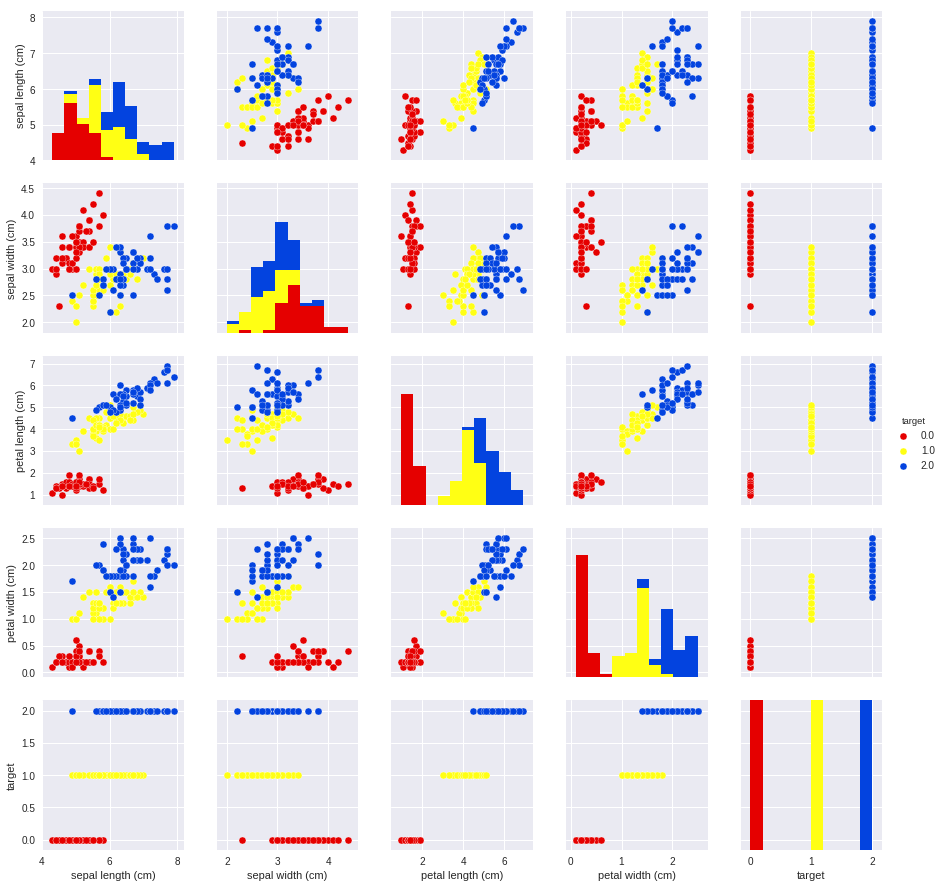

In [3]:
colors = ['red', 'yellow', 'blue']
sns.pairplot(iris_df, hue='target', palette=sns.xkcd_palette(colors))

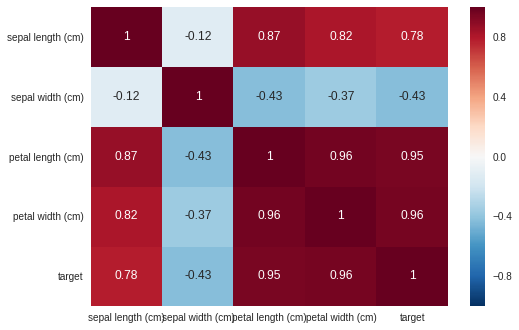

In [4]:
corr = iris_df.corr()
sns.heatmap(corr, annot=True)

## 3- Preparing the data

### Getting the names of the target

In [0]:
iris_df['target'] = iris_df['target'].map({0: iris['target_names'][0],
                                          1: iris['target_names'][1],
                                          2: iris['target_names'][2]})

### Feature selection

To illustrate how the decision tree works, we need to work on 2D graphs so we select two features. We select petal width and sepal width because there not too correlated (-0.37), as we can see on the heatmap, and in a 2D plane they give a good separation of the target variable as we can see on the pairplot.

In [0]:
# drop the duplicates so that we can every dot on the graph
iris_df = iris_df.drop_duplicates(subset=['petal width (cm)', 'sepal width (cm)'], keep='first')
features = ['petal width (cm)', 'sepal width (cm)']
X = iris_df[features]
y = iris_df['target']


### Splitting into training and testing set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## 4- Modeling

### Choosing a model

In [0]:
model = DecisionTreeClassifier()

### Training

In [9]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 5- Evaluating the model

In [0]:
y_pred = model.predict(X_test)

### Accuracy

In [11]:
accuracy_score(y_test, y_pred)

0.9333333333333333

The accuracy is not very good but it is not what interests us in this notebook. Btw, we only choose two variables. Let's see for which classes the model makes mistakes.

### Confusion matrix

Text(0.5, 1.0, 'Confusion matrix')

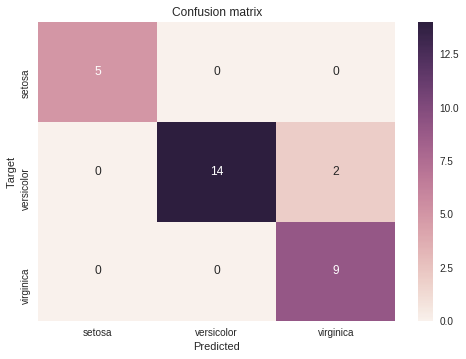

In [12]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['setosa', 'versicolor', 'virginica'], 
            yticklabels=['setosa', 'versicolor', 'virginica'])
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Confusion matrix')

We can see that the versicolor was mispredicted for virginica twice. <br/>

## 6- Understanding how the model builds its decision
Having a good prediction is interesting but understanding how the model has built its predicting path is essential. <br/>
In the following section, we will study the previous given graph step by step for each depth of the graph. <br/>
After this section you will be able to :
*  decrypt a decision tree
*  understand the concept of decision boundary


### Tree graph

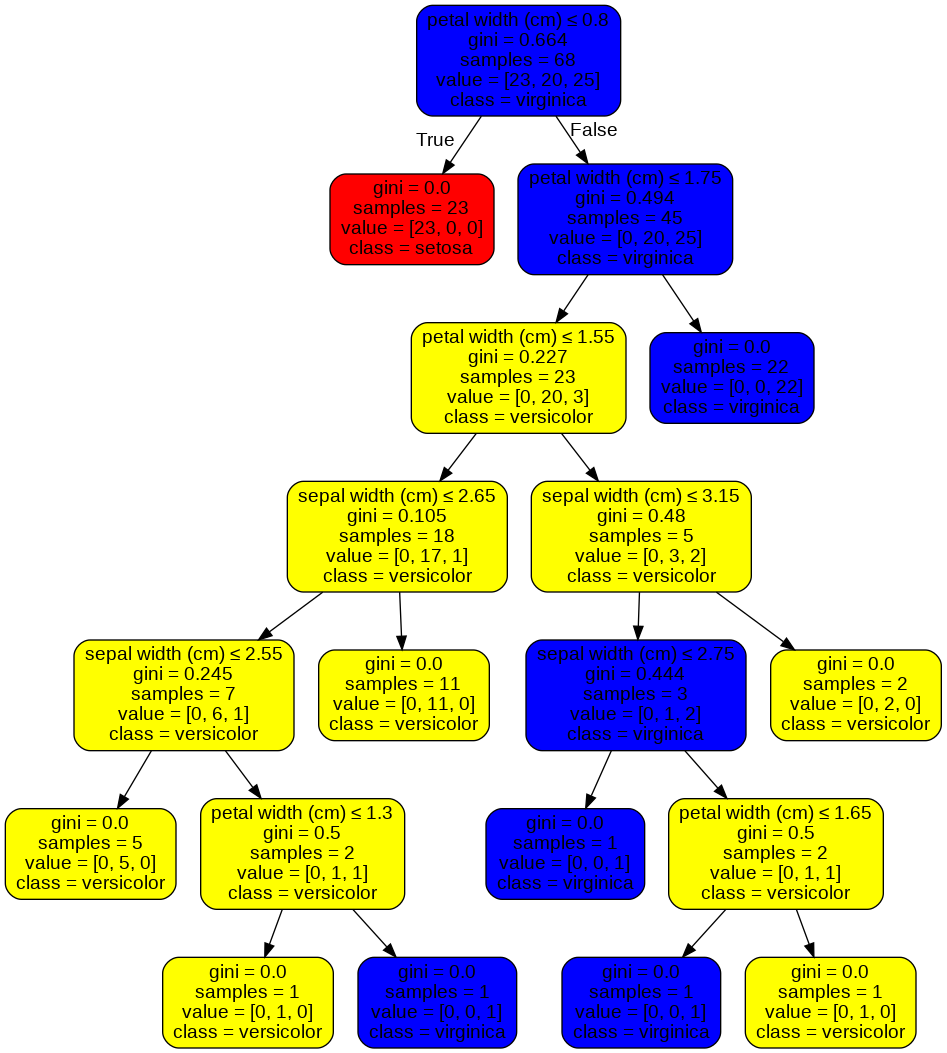

In [13]:




dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=features,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('red', 'yellow', 'blue')
nodes = graph.get_node_list()

for node in nodes:
  if node.get_label():
    values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
    color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2])
    node.set_fillcolor(colors[np.argmax(values)])

graph.write_png('colored_tree.png')



def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

viewPydot(graph)



### Analysing the tree

#### Utility code

In [0]:
def get_lines(depth, lim, node_n=0):
  '''
  Fetches the lines corresponding to the decision boundaries for the tree
  at given depth
  depth : depth maximum where to fetch the lines
  lim : the frame defined to plot the graph
  node_n : node to fetch the lines
  '''
  seg = np.zeros((2,2))

  if depth==-1:
    return seg
  else:
    f = model.tree_.feature[node_n]

    lc_node_n = model.tree_.children_left[node_n]
    rc_node_n = model.tree_.children_right[node_n]

    if f<0:
      return seg
    else:
      thres = model.tree_.threshold[node_n]

      seg[f,:] = thres
      seg[1-f,:] = lim[1-f,:]

      if (lc_node_n==-1) and (rc_node_n)==-1:
        return seg
      else:
        l_lim = lim.copy()
        r_lim = lim.copy()

        l_lim[f, 1] = float(thres)
        r_lim[f, 0] = float(thres)

        seg = np.concatenate((seg, get_lines(depth-1, l_lim, lc_node_n)), axis=0) if not np.array_equal(get_lines(depth-1, l_lim, lc_node_n), np.zeros((2,2))) else seg
        seg = np.concatenate((seg, get_lines(depth-1, r_lim, rc_node_n)), axis=0) if not np.array_equal(get_lines(depth-1, r_lim, rc_node_n), np.zeros((2,2))) else seg
        return seg
      
    
def get_decision_boundaries(depth, lim):
  '''
  Wrapper and formatter of the get_lines function
  '''
  segs = get_lines(depth, lim)
  segments = []
  for i in range(0,len(segs),2):
    segments.append(segs[i:i+2,:])
  return segments



In [0]:
def get_pred(feat, depth, node_n=0):
  '''
  Get the predictions of the decision tree at a given depth.
  feat : coordinates (features) of the point
  depth : depth at which the prediction is computed
  node_n : node_n deciding the prediction
  '''
  f = model.tree_.feature[node_n]
  # leaf
  if f<0:
    pred = np.argmax(model.tree_.value[node_n])
    return pred
  elif depth==0:
    pred = np.argmax(model.tree_.value[node_n])
    return pred
  else:
    if (feat[f]<=model.tree_.threshold[node_n]):
      lc_node_n = model.tree_.children_left[node_n]
      return get_pred(feat, depth-1, lc_node_n)
    else:
      rc_node_n = model.tree_.children_right[node_n]
      return get_pred(feat, depth-1, rc_node_n)

#### Visualizing the decision tree

In [0]:
def plot_decision(depth, boundaries=True):
  
  plt.style.use('seaborn-white')

  labels = iris['target_names']
  plot_colors = 'ryb'
  plot_step = 0.02

  # We define a grid of points from which we will make predictions
  x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
  y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))

  lim = np.array([[x_min, x_max-0.02],[y_min,y_max-0.05]])

  # Plot the background color which depicts the decision of the tree
  Z = []
  for feat in np.c_[xx.ravel(), yy.ravel()]:
      Z.append(get_pred(feat,depth))
  Z[0]=1
  Z = np.array(Z).reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, zorder=0)

  if boundaries:
    # Plot the boundaries of the decision tree
    segments = get_decision_boundaries(depth, lim)
    for seg in segments:
      plt.plot(seg[0,:], seg[1,:], 'k-')

  # Plot the training data
  for j, (species, color) in enumerate(zip(labels, plot_colors)):
    idx = y_train.index[y_train==species]
    plt.scatter(X_train.loc[idx][features[0]], X_train.loc[idx][features[1]], c=color, label=labels[j], cmap=plt.cm.RdYlBu, edgecolor='black', s=30, zorder=1)

  legend = plt.legend()
  plt.xlabel(features[0])
  plt.ylabel(features[1])
  plt.title('Decision tree at depth {}'.format(depth))

##### Node 0

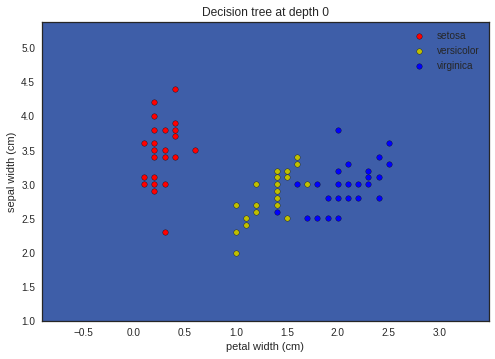

In [17]:
plot_decision(0, False)

On this graph we can see what is happening on the root node of the tree.


**Decision** 

On the root node, all the data points are mixed. There are 25 virginica irises, 20 versicolor irises, 23 setosa irises. The virginica is the most numerous species, so the tree chooses virginica to classify the irises at the root nodes.  

##### Node 0

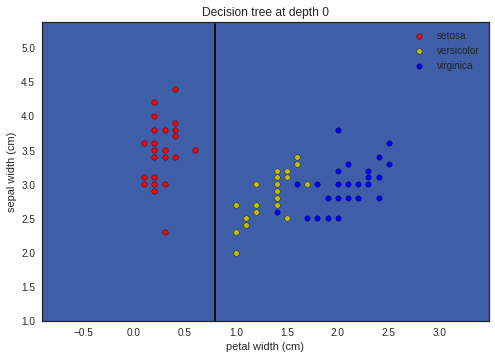

In [18]:
plot_decision(0, True)

This plot is the same as the previous one but with the first decision boundary of the tree : `petal width = 0.8 cm`. 

**How was this decision boundary decided ? **

A decision boundary is decided by testing all the possible decision boundaries splitting the dataset and choosing the one that minimizes the Gini impurity of the two splits. 

**What is Gini impurity ?**

Gini impurity is a metric that measures the probability from a randomly chosen element to be incorrectly classified, i.e. the probability $p_i$ of choosing an element $i$ times the probability of being misclassified  $\sum_{k!=i} p_k = 1 - p_i$. If we sum over all $J$ possible classes we have : 
$\sum_{i=1}^{J}p_i \sum_{k!=i}p_k = \sum_{i=1}^{J}p_i(1-p_i) = \sum_{i=1}^{J} (p_i - p_i^2) =  \sum_{i=1}^{J} p_i - \sum_{i=1}^{J} p_i^2 = 1 - \sum_{i=1}^{J} p_i^2 $

This is the last formula we are going to use to perform the Gini test.


**Let's compute the Gini impurity for the first node **

At the root node all the data points are mixed. Gini impurity is $1 - p_{se}^2 - p_{ve}^2 - p_{vi}^2$ with :
* $p_{se}$  the probability of choosing a setosa;
* $p_{ve}$ the probability of choosing a versicolor;
* $ p_{vi}$ the probability of choosing a virginica.
This gives us : $1- (\frac{23}{68})^2 - (\frac{20}{68})^2 - (\frac{25}{68})^2 = 0.664$

We can verify this number by checking the tree we displayed earlier. For the first node we have a Gini impurity of 0.664.



**Let's get back to the first decision boundary**

The question to be asked is : how to split the iris species so that we create more homogeneous groups ? <br/>
Intuitively what we can observe that we can create a homogeneous group containing only setosa species just by splitting the dataset along the `petal width` axis.

**But the algorithm has no intuition. So how does it find the best split ? ** <br/>
It will try all the possible boundaries along all the features, i.e. all the axes `petal width` and` sepal width`. For each split the algorithm will compute the Gini impurity of the two groups. Finally it will choose the decision boundary that give the lowest Gini impurity for the two groups (either summing the Gini impurity for each group or doing a mean).

**Let's get back to the first node and the first split ** <br/>
In the case of the root node, the algorithm has found that among all the possible splits the split with `petal width <= 0.8`. <br/>
The Gini impurity for the left leaf is :
$1 - p_{se}^2 - p_{ve}^2 - p_{vi}^2 = 1 - p_{se}^2 = 1 - (\frac{23}{23})^2=0$. We verify this result with the tree graph. This result is not surprising because in the left leaf which matches the left part of the graph we only have setosa iris, so the group is very homogenous and Gini impurity is a measure of homogeneity. <br/>
The Gini impurity for the right leaf is : <br/>
$1 - p_{se}^2 - p_{ve}^2 - p_{vi}^2 = 1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{20}{45})^2 - (\frac{25}{45})^2 = 0.494$. We find the same result as the one shown in the tree graph. Moreover this Gini impurity is close to 0.5 because there are almost as much virginica irises as versicolor.


##### Node 1

The process described will continue iteratively until the tree succeeds or tries to separate all the data points or a restrictive condition is applied to the algorithm like a limitation in the depth of the tree. 

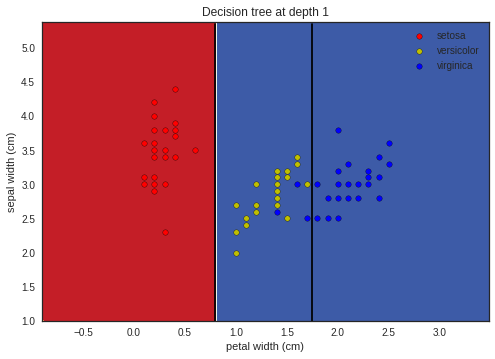

In [19]:
plot_decision(1)

As the Gini impurity is 0 for `petal width <= 0.8`, i.e. we cannot have a more homogenous group, the algorithm will not try to split this part anymore and will focus on the right part of the tree. 

Intuitively, the decision tree continues to use the `petal width` feature to split the right part in two. Indeed, it seems easier to create homogenous groups using `petal width` instead of `sepal width`. Splitting at `petal width = 1.75` creates a group with only virginica irises (so with a Gini impurity of 0). Managing to create a group with uniquely one species is not always the best option though as we will see in the next split...

As the algorithm has created a node with only virginica, this node will never be split again and it will be a leaf.

##### Node 2

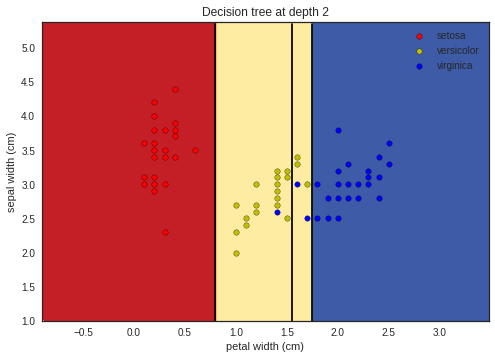

In [20]:
plot_decision(2)

For this node the algorithm chose to split the tree at `petal width = 1.55` creating two heterogenous groups. Intuitively we would have split at `petal width = 1.3` or `sepal width = 3.1 ` to create a group with only versicolor irises. Indeed this would have created a node with a Gini impurity at 0. But in fact the other node created is more heterogenous so much so that the Gini impurity of this node is bigger than the Gini impurity of the sum of the two nodes created with the other split. 

**Let's verify this :**

**Gini impurity with the split at `petal width = 1.55`**
* Left node : $1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{17}{18})^2 -  (\frac{1}{18})^2 = 0.105 $. We verify this result on the tree.
* Right node : $1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{3}{5})^2 -  (\frac{2}{5})^2 = 0.48 $. Again we verify this result on the tree. <br/>
The Gini impurity for this split is : $\frac{18}{18+5} * 0.105 + \frac{5}{23} * 0.48 = 0.187$. The Gini index for this split is ponderated by the number of points for each group.

**Gini impurity with the split at `petal widht = 1.3`**
* Left node : $1 - p_{ve}^2 = 1 - \frac{8}{8}^2 = 0$
* Right node : $1 - p_{ve}^2 - p_{vi}^2 = 1 - (\frac{12}{15})^2 -  (\frac{3}{15})^2 = 0.32$ <br/>
The Gini impurity for this split is : $\frac{8}{23} * 0 + \frac{15}{23} * 0.32 = 0.209$

The algorithm is right and our intuition was wrong. Indeed the first split produces the lowest Gini impurity so this split is preferable.
The algorithm tries each possible split for each feature.

##### Nodes 3

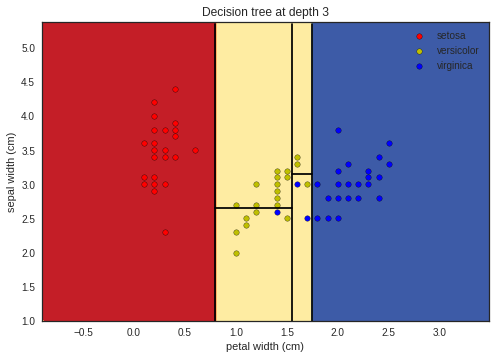

In [21]:
plot_decision(3)

The first thing to notice is that the previous split has not changed the decision function of the tree below and above the split `petal width = 1.55`. Indeed for both nodes created, the versicolor still holds the majority.  

For this level, the decision tree finally uses the `sepal width` feature. The two split creates are `sepal width = 2.65` for `petal width <= 1.55` and `sepal width = 3.15` for `sepal width > 1.55`.

##### Following nodes 

6


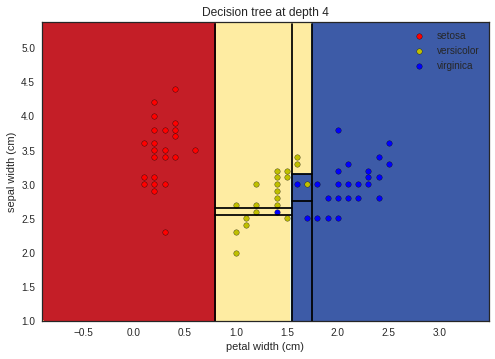

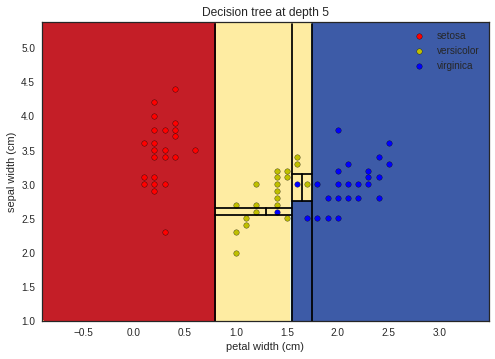

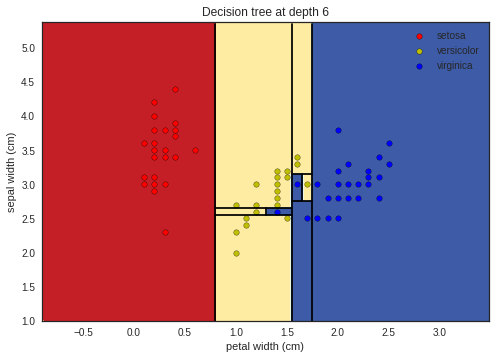

In [22]:
  tree_depth = model.tree_.max_depth
  print(tree_depth)
  for i in range(4, tree_depth+1):
    plot_decision(i)
    plt.show()

Applying the same principle again and again the algorithm will try to isolate every point until it has only homogenous groups. This is called **overfitting**.  The tree is learning by heart the training set instead of understanding it which will enable him to make good predictions on the testing set. 

### Now that the decision tree is built let's see how it is doing on the testing set

In [0]:
def plot_final_decision():
  
  plt.style.use('seaborn-white')

  labels = iris['target_names']
  plot_colors = 'ryb'
  plot_step = 0.02

  # We define a grid of points from which we will make predictions
  x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
  y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))

  lim = np.array([[x_min, x_max-0.02],[y_min,y_max-0.05]])

  Z = []
  for feat in np.c_[xx.ravel(), yy.ravel()]:
      Z.append(get_pred(feat,tree_depth))
  Z[0]=1
  Z = np.array(Z).reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, zorder=0)

  # Plot the boundaries of the decision tree
  segments = get_decision_boundaries(tree_depth, lim)
  for seg in segments:
    plt.plot(seg[0,:], seg[1,:], 'k-')


  # Plot the training and testing data
  for j, (species, color) in enumerate(zip(labels, plot_colors)):

    # Plotting the training data
    idx = y_train.index[y_train==species]
    plt.scatter(X_train.loc[idx][features[0]], X_train.loc[idx][features[1]], c=color, label=labels[j], cmap=plt.cm.RdYlBu, edgecolor='black', s=30, zorder=1)

    # Plotting the testing data
    test_idx = y_test.index[y_test==species]
    plt.scatter(X_test.loc[test_idx][features[0]], X_test.loc[test_idx][features[1]], c=color, label=labels[j], marker='x', cmap=plt.cm.RdYlBu, edgecolor='black', s=30, zorder=1)

  legend = plt.legend()
  plt.xlabel(features[0])
  plt.ylabel(features[1])
  plt.title('Final decision tree boundaries with the training (x) and testing points (o)')

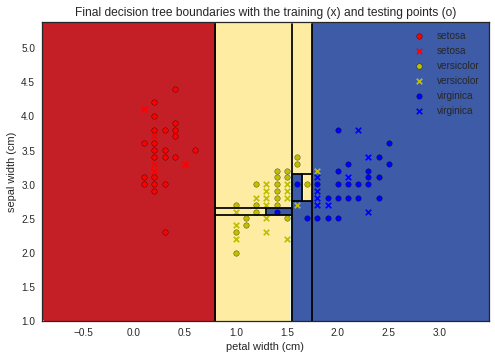

In [24]:
plot_final_decision()

On the plot above we can see the training data (represented by o) on which the algorithm has been trained (and has overfitted) and the the testing data (represented by x).

As we have seen with the confusion matrix two versicolor have been misclassified for viriginica : 
* for `1.55 < petal width <= 1.75` and `sepal width <= 2.75`
* for `petal width > 1.75`

The rest of the testing irises have been well classified which gives us an accuracy of 0.93.

During the testing phase, the algorithm takes every point and travels across the decision tree choosing the left or right node according to the feature value of the iris being tested.